In [119]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# Functions and classes to ease the work

In [ ]:
def get_pool_v2_reserves_history(contract_id: str) -> list:
    sample_transport = RequestsHTTPTransport(url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2',
                                            verify=True, retries=3)
    
    client = Client(transport=sample_transport)
    
    daily_data = []
    last_date = 0

    for skip in tqdm(range(0, 2)):
        try:
            contract_id = contract_id
            query = gql(
                'query{\n'
                 'pairDayDatas(first: 1000, orderBy: date, orderDirection: asc,\n'
                   'where: {\n'
                     f'pairAddress: "{contract_id}",\n'
                     f'date_gt: {last_date}\n'
                   '}\n'
                 ') {\n'
                     'date\n'
                     'dailyVolumeToken0\n'
                     'dailyVolumeToken1\n'
                     'dailyVolumeUSD\n'
                     'reserveUSD\n'
                     'reserve0\n'
                     'reserve1\n'
                 '}\n'
                '}\n'
            )

            response = client.execute(query)
            last_date = response['pairDayDatas'][-1]['date']
            daily_data.extend(response['pairDayDatas'])

        except Exception as e:
            print(e)
            
    return daily_data


def list_to_reserves_dictionary(daily_reserve: list) -> dict:
    """
    transform daily reserve information list into daily reserve information dictionary
    """
    # reserve information
    reserve0 = daily_reserve['reserve0']
    reserve1 = daily_reserve['reserve1']
    reserveUSD = daily_reserve['reserveUSD']
    
    # daily volume info
    dailyVolumeToken0 = daily_reserve['dailyVolumeToken0']
    dailyVolumeToken1 = daily_reserve['dailyVolumeToken1']
    
    # date of reserve info taken
    date = daily_reserve['date']
    
    return {
        'reserve0': reserve0,
        'reserve1': reserve1,
        'reserveUSD': reserveUSD,
        'dailyVolumeToken0': dailyVolumeToken0,
        'dailyVolumeToken1': dailyVolumeToken1,
        'date': date
    }


def get_pool_v2_history(contract_id: str, range_limit: int=100) -> list:
    """
    function performs api call to the Uniswap v2 and gets history of required contract
    considering timestamps
    """
    sample_transport = RequestsHTTPTransport(url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2',
                                            verify=True, retries=3)

    all_swaps = []
    last_timestamp = 0

    client = Client(transport=sample_transport)

    for skip in tqdm(range(0, range_limit)):
        try:
            query = gql(
            'query {\n'
                f'swaps(first: 1000, where: {{ pair: "{contract_id}", timestamp_gt: {last_timestamp} }} orderBy: timestamp, orderDirection: asc) {{\n'
                'transaction {\n'
                    'id\n'
                    'timestamp\n'
                '}\n'
                'id\n'
                'pair {\n'
                    'token0 {\n'
                    'id\n'
                    'symbol\n'
                    '}\n'
                    'token1 {\n'
                    'id\n'
                    'symbol\n'
                    '}\n'
                '}\n'
                'amount0In\n'
                'amount0Out\n'
                'amount1In\n'
                'amount1Out\n'
                'amountUSD\n'
                'to\n'
                '}\n'
            '}\n')

            # get current response and extract from it last timestamp
            response = client.execute(query)
            last_timestamp = response['swaps'][-1]['transaction']['timestamp']

            # extend swaps history with current response
            all_swaps.extend(response['swaps'])

        except Exception as e:
            print(e)

    return all_swaps


def list_to_transaction_dictionary(transaction: list) -> dict:
    """
    transform list of transaction info into dictionary of transaction info
    """
    if transaction['amount0In'] != '0':
        token_in = transaction['pair']['token0']['symbol']
        token_out = transaction['pair']['token1']['symbol']
        amount_in = transaction['amount0In']
        amount_out = transaction['amount1Out']
    else:
        token_in = transaction['pair']['token1']['symbol']
        token_out = transaction['pair']['token0']['symbol']
        amount_in = transaction['amount1In']
        amount_out = transaction['amount0Out']
        
    amount_usd = transaction['amountUSD']
    timestamp = transaction['transaction']['timestamp']
    
    return {
        'token_in': token_in,
        'token_out': token_out,
        'amount_in': amount_in,
        'amount_out': amount_out,
        'amount_usd': amount_usd,
        'timestamp': timestamp
    }


def pool_history_to_df(pool_history: list) -> pd.DataFrame:
    """
    transform list-like pool history into pandas dataframe
    """
    # transform transactions list of lists into list of dictionaries
    all_swaps_transformed = [list_to_transaction_dictionary(swap) for swap in pool_history]

    # make a dataframe from list of dictionaries and fix data type for specific columns
    swaps_df = pd.DataFrame(all_swaps_transformed)
    swaps_df.timestamp = pd.to_datetime(swaps_df.timestamp, unit='s')
    swaps_df['amount_in'] = swaps_df['amount_in'].astype('float')
    swaps_df['amount_out'] = swaps_df['amount_out'].astype('float')
    swaps_df['amount_usd'] = swaps_df['amount_usd'].astype('float')

    return swaps_df


def pool_reserves_to_df(reserves_list: list) -> pd.DataFrame:
    """
    transform list-like reserves history into pandas dataframe
    """
    
    # transform list of dictionaries into df
    daily_data_df = pd.DataFrame([list_to_reserves_dictionary(x) for x in reserves_list])
    
    daily_data_df['reserve0'] = daily_data_df['reserve0'].astype('float')
    daily_data_df['reserve1'] = daily_data_df['reserve1'].astype('float')
    daily_data_df['reserveUSD'] = daily_data_df['reserveUSD'].astype('float')
    daily_data_df['dailyVolumeToken0'] = daily_data_df['dailyVolumeToken0'].astype('float')
    daily_data_df['dailyVolumeToken1'] = daily_data_df['dailyVolumeToken1'].astype('float')
    daily_data_df['date'] =  pd.to_datetime(daily_data_df['date'], unit='s')
    
    return daily_data_df

In [128]:
def show_swaps_count_moving_averages(swaps_df: pd.DataFrame, pool_name: str, x_size: int=10, y_size: int=5):
    # transform unix timestamps into datetime
    transactions_time = swaps_df.copy()
    transactions_time.timestamp = pd.to_datetime(swaps_df.timestamp, unit='s')
    
    # set index datetime column
    transactions_time.index = transactions_time.timestamp
    
    # resample data and find rolling average per week
    transactions_time = transactions_time.resample('1D').size()
    transactions_avg_time = transactions_time.rolling('7D').mean()
    
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    fig.autofmt_xdate()

    # plot presented information
    ax.plot_date(transactions_time.index, transactions_time, linestyle='solid', marker=None, 
                 label='Number of swaps per day')
    ax.plot_date(transactions_avg_time.index, transactions_avg_time, linestyle='solid', marker=None, color='red', 
                 label='Moving average 7 days')
    
    # set labels
    ax.set_xlabel("Day")
    ax.set_ylabel("Count")
    ax.set_title("Daily swaps count of pool " + pool_name)
    fig.legend()
    

def show_swaps_reserves_evolution_through_time(swaps_df: pd.DataFrame, first_token_symbol: str, second_token_symbol: str, 
                                               pool_name: str, x_size: int=10, y_size=5):
    fig, ax1 = plt.subplots(figsize=(x_size, y_size))

    ax2 = ax1.twinx()
    fig.autofmt_xdate()

    ax1.plot_date(swaps_df.date, swaps_df.reserve0, linestyle='solid', marker=None, label=first_token_symbol)
    ax2.plot_date(swaps_df.date, swaps_df.reserve1, linestyle='solid', marker=None, color='red', label=second_token_symbol)

    ax1.set_title("Daily reserve values for pool " + pool_name)
    fig.legend()

    ax1.set_ylabel(first_token_symbol)
    ax2.set_ylabel(second_token_symbol)
    
    
def show_pool_price_evolution_from_reserves(df: pd.DataFrame, first_arg: str, second_arg: str, 
                                            pool_name: str, x_size: int=10, y_size: int=5):
    df['price'] = df[first_arg] / df[second_arg]
    fig, ax1 = plt.subplots(figsize=(15, 9))

    ax2 = ax1.twinx()

    ax1.plot_date(df.date, df.price, linestyle='solid', marker=None, label='Number of transactions')
    ax1.set_title("Price " + pool_name)
    
    
def show_swaps_amount_in_moving_averages(swaps_df: pd.DataFrame, pool_name: str, x_size: int=10, y_size: int=5):
    # transform unix timestamps into datetime
    transactions_time = swaps_df.copy()
    transactions_time.timestamp = pd.to_datetime(swaps_df.timestamp, unit='s')
    
    # set index datetime column
    transactions_time.index = transactions_time.timestamp
    
    # resample data and find rolling average per week
    transactions_time = transactions_time.resample('1D').mean()
    transactions_avg_time = transactions_time.rolling('7D').mean()
    
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    fig.autofmt_xdate()

    # plot presented information
    ax.plot_date(transactions_time.index, transactions_time.amount_in, linestyle='solid', marker=None, 
                 label='Number of swaps per day')
    ax.plot_date(transactions_avg_time.index, transactions_avg_time.amount_in, linestyle='solid', marker=None, color='red', 
                 label='Moving average 7 days')
    
    # set labels
    ax.set_xlabel("Day")
    ax.set_ylabel("Value")
    ax.set_title("Daily swaps in of pool " + pool_name)
    fig.legend()

# reading ETH/USDC uniswap v2 data

In [ ]:
eth_usdc_history = get_pool_v2_history(contract_id='0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc', range_limit=4000)
eth_usdc_df = pool_history_to_df(eth_usdc_history)

  8%|████████████▊                                                                                                                                                           | 306/4000 [10:39<2:09:36,  2.11s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-c749106148a6ef3e */\\nselect \'Transaction\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"transaction\\" c where c.\\"block_range\\" @> $3 and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x002abdd6a483ca1ce0ff4cbf63a97e61b6a5d9ed290e76475a9b4940ea3d2ce4-0\\", \\"0x013de1c89320966825549d9e50d3b0485819220a16b952d72d75d2cfba432658-1\\", \\"0x015b95313869b45417abb7106f01df67fef104edf87f09d77d1d883bb92dcb29-0\\", \\"0x01b91d2e277484ef8ae7f60d7e7723166c6f2b891372b71794f137217778f19c-1\\", \\"0x01c54a6ea109b0e1315c8f4d0a3bcf34dbc59532651b3dadf6f622eff9f0840e-0\\", \\"0x01f85dc6653cd29e7b2799e06dbe1088a9e8a3ea48b4655c9cef0462c6be655c-0\\", \\"0x0213676d6663be09d98d36502c7167648967aa2bb63dacfb60eb5d87e1a3cb18-1\\", \\

  8%|█████████████▋                                                                                                                                                          | 327/4000 [11:24<1:59:08,  1.95s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-184beac16fb23a7a */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x002f601b94aaa3fa9506ae88a27a6332c8ef0dc9e4db90c80403e34e31a1fa88-0\\", \\"0x0042480bed6b27b34b9c5b6e673b1f11bf081ce4e42bf2cb14b1e9ab6c55ebf7-1\\", \\"0x00aa298caa32cb00d7bbf856a8b4c9037fb1a10fa20aa74fd18782cb396d266b-1\\", \\"0x00e009c271871dcc4215a1c4c18db99c76dda737fd91990cf15717ed82c99ae8-0\\", \\"0x014e431674ed0638eb66765283bbad731065ae4463427d39e4f2d720e39c3ed3-1\\", \\"0x01c26b310683dec0b82603d22793460b214beddbd557ba21d7fe68e29d83d3f8-0\\", \\"0x0202e6d8b9282fd47efc9fd494773c0be88d2c8a9c0bb2960c45b0c59e70

  9%|███████████████▎                                                                                                                                                        | 365/4000 [12:44<1:48:17,  1.79s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-c061e95023af0e4e */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x0011e1dc82e10c7e7210246ab9e29571c0d7c84d1f420e5f7312d66f5efa0857-1\\", \\"0x00e4c6f9ffdb13c840c1b0abd75586313d2bacefb6dd05d987f8d05b29f7ada8-0\\", \\"0x0121bcbf836c8b092186d9dc71e8782e33452e8c10b376094c667878f60aa057-2\\", \\"0x0194104009da3898708df12e3f67ad626b2a904ad676dd080e76792844cfbdd3-1\\", \\"0x019b16fa2fe57f87d791e39fa22f0c6340cb0fb77044066317f6f539907da10f-0\\", \\"0x01b3967b4332e5148046c1910ee61c6bf2da9d636108e735876352a9a86dca89-0\\", \\"0x020874fbbc011a0c3f6bffb42fc4c693c3c21e3707b9422e260dda6d4cfc

 13%|█████████████████████▌                                                                                                                                                  | 512/4000 [18:01<1:49:33,  1.88s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-2b7b081e3d4d1d43 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x00251e73848a65ca411954d105e2a1d4b66de72e517e4677235f7a8e2934ec9c-1\\", \\"0x00b3498cbeae65a2f2bb25d4adc64b31ffeb78565baff7c1bcc5d2e62c3e43ba-0\\", \\"0x00bc0bb0d7efd1fe106725c121f77b2f973b3df0373a59cc90880bc192d9b654-0\\", \\"0x00e4c10f7a3aece0e7c7f1103508287a97f4b21ea1c99a59c810cd851d08d5a7-0\\", \\"0x016981ae51f43928936e7c3237cfd94b686dd0cde209815ee41ec69efd75082f-0\\", \\"0x018f5361a7f51a3d3d623cdf9b127293efe04baa8132d4460be8698f1d69f45d-0\\", \\"0x0195e95c260463d507c1f48aa46af7327bbbb262150ca07bcae8fccfdb2b

 17%|█████████████████████████████▎                                                                                                                                          | 699/4000 [24:26<1:41:33,  1.85s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-290c8a5e8f3f0cf3 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x007a6e2a953143ba5b12ce618db61ec7c09d230c712096d24000d5485d38419d-0\\", \\"0x009070b5ee1688e713d63e4e3b4b97c4fa15ef886a28eec704fa142e342e4a5d-0\\", \\"0x0119f1bed7a2bbacd81cf00d17f01d90b4ea0d60f05c2e07f8a6d139bea82d7e-1\\", \\"0x0148fbef30c21ddc4216ea7ce8819ac9ce2723e78fc9b2227f9a3e35a35260c9-1\\", \\"0x01885f46904215782dd82339836aea9009c54beb733f23810efb69cb262e76a1-0\\", \\"0x01ca5129a864d763d3edae1173d468d9df0d0b889c0b8d5be16bbbecf7fd1e4f-0\\", \\"0x0260c4191cdfbdb2b44a82502bcb8c96033d0857822faddf243e039a2bd8

 21%|███████████████████████████████████                                                                                                                                     | 836/4000 [29:12<1:34:04,  1.78s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-78b105d96e4b76db */\\nselect \'Transaction\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"transaction\\" c where c.\\"block_range\\" @> $3 and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x000962f89de1463407ef4fe3d1a7b2c33c2e2cce82ee93a9930dbd2a768deccb-1\\", \\"0x002aee71d59afce71947a305ca12f808abf445b9dc4af487a8e6fe5be7bd33eb-0\\", \\"0x005625916cf090cad8a132d1675a3f47d339afda929248d15f3e4e9af0999714-1\\", \\"0x00ffd6e5d42f94531ade188a106d2c4ff1042e58052436527616a13b5b797ea4-1\\", \\"0x014f9c99930339c4f482d5183ad1b598edc766fa95b487a257694dba2e77ca48-1\\", \\"0x017f7022110f62c3796a45a3111278dce44e4c80f811d4babab81a9e5eeaf568-1\\", \\"0x01a57237e929bee53de7171a6da01f763233110c72371f4358c735b398fed6b5-0\\", \\

 22%|████████████████████████████████████▏                                                                                                                                   | 862/4000 [30:04<1:30:44,  1.73s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-2b52f6d5a35cad84 */\\nselect \'Transaction\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"transaction\\" c where c.\\"block_range\\" @> $3 and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x000150c41d60c0d21d9f24230c8a946416fb567a0471beab7061fd9a367cb0e1-1\\", \\"0x015263eb4a5fb14efc32433b50077ce7b3fc80f323f3183f8cefc191802a90db-1\\", \\"0x0167db8ebe928e55749a112cdbb38bef7861c98ec555dcc95ebb7ab6e9127571-0\\", \\"0x01a309eb31f3739c20b7ead2437acdd4ae4f10f01253b40a25b4c23ee68be081-2\\", \\"0x02139c7492c6cff2a34d0d08d387a7bf05dbc3c88b74c18f30ed02565e2fadf1-0\\", \\"0x0237bbf18095900d76c3afcb3306e184a23b959df17f18d4b21e87a20167a031-1\\", \\"0x02b53c60651b67eef31c4e74a04d5576aec050b4f65799c631dd2d75a4af107a-0\\", \\

 26%|███████████████████████████████████████████▍                                                                                                                           | 1039/4000 [36:12<1:26:04,  1.74s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-ae2af7d77f0ef314 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x0004f10f4a0cfecdb6958337868f75fb3a39487ffb6520010ea1cfcdd5beb983-0\\", \\"0x003fc404e062552dc7a93192d4803c72ac0cfc46bf8a95af6acb1778301ff31b-1\\", \\"0x008055f5bfe29701c406c8998a2f19a386e5a3ab63de9ad4d227e6d3c4532190-1\\", \\"0x008ec1506bc14a48e9d5e44c39743fdadc5da60716a5860d94f10057c8400e80-1\\", \\"0x00d195194ad59d8e515af9bbffb65567da3c84ec4316c49b1e8bf7dc5ac1ca55-0\\", \\"0x00f2263b51da9efef24c4bbb63bcc16d034a47f480cd6e7d25583c152ce97d16-0\\", \\"0x00fd343e5f585a5ed8f17bc4fe9972ef988e3dd47ad317d1f4fe536f4800

 29%|███████████████████████████████████████████████▊                                                                                                                       | 1144/4000 [39:57<1:33:19,  1.96s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-ad7fe1b1e8f37b82 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x00534cae5b0e6be0fdd0369eff7db71ed781815cf48e5bdb850836de11532e3c-0\\", \\"0x007228529599a7053151e7880b7c9a0a3fcfb40d22325a355f40779e2ba58ae7-0\\", \\"0x00d4278ab7fd487e0908aa08001cd559fa811bd11ac3b216d279598966f3f524-0\\", \\"0x00e6ef4548856d23fdab420d0ca9358ea01db08d2654d06aee7e5c7490b64bbe-0\\", \\"0x00e7d9a1e80731ea5c6e749495109e7c35e741fe3e7f2815280b4a15bfe0c210-1\\", \\"0x011409d284d18affb918edf8ececf579a6f6397557c3692b01926f9109ca4ad4-3\\", \\"0x01708c8f26a6e054cc5cfbd661657e65383467ff6ec38823b30b4c714aa8

 29%|████████████████████████████████████████████████▏                                                                                                                      | 1153/4000 [40:16<1:33:03,  1.96s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-6871ec12fd794611 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x007a28cdd9ff15defa773cafe14603d0b9e18aff87b46950d7012b8dbe002c36-0\\", \\"0x008754755fead368ee52e501d35b8a5b456ffdd2fa1382ef71088f83deca3aa4-0\\", \\"0x00ab6157be1a383a345947af59fea54f495379c95a3b0a1654bdb229672bf388-0\\", \\"0x019445005b1b395862046afdf367ed6908429c7f874a59191748fde887ff9613-1\\", \\"0x019a5475e6c34682b65898a1a937c65008bf1e8f13fd677bdd8e85345291fd41-0\\", \\"0x01ccfa41f8eaa846e9950f6b7bbf7af7af39ca50bcb2915ca391b88029583d6f-1\\", \\"0x0202dc53de8d3889b80ca183b886e609bbe2995df20f4c8fbedd5c58123b

 34%|████████████████████████████████████████████████████████                                                                                                               | 1344/4000 [46:59<1:18:33,  1.77s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-5f9d81ddd8fd03ba */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x000240b6aad162f8f4ebb0d764f9c42dead7f993d7acee5a07a746aff06e1cb5-2\\", \\"0x00a9e6a9617136a8ededc886f6287abe5c20b46f3e633f5997b07fe116091db3-0\\", \\"0x011c42e599f47b4ad4b8be8b46b29aa0aed74f9dd2d898b2cfb39dd2deb1d8e1-0\\", \\"0x01719b1178e193f0e30d82499fed177259dd87ad2a7432b8604fc561c9a848b1-0\\", \\"0x02021c3a2d8645336172c687bd86fdc3341813231522be2b615777e4ff0e3ad5-0\\", \\"0x021202222f6ba192ff30e5952a55dca3c40c77325be471e3392c936e84d670be-0\\", \\"0x021a3a846d67241b9cd09dee12078d5bfef334095d46de2b7c6d126e645d

 36%|████████████████████████████████████████████████████████████▌                                                                                                          | 1452/4000 [50:46<1:14:02,  1.74s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-fb26a22f312043de */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x006270d8cb0f78112a8fa34180d7b8b18c0f5745d64f191e696dcbd5b957e05f-0\\", \\"0x0084ae672c7cf4c2e74f903208fe36a7bea54b91d8ad957d479b1b10536256f3-1\\", \\"0x00f4a20e8e30b23af00c337a11d86f48479f2ee768b9e95131a454f04b324a2b-0\\", \\"0x011630504fa427805fcda8203033c03bd6f46cdf762daece496a089a7754675b-0\\", \\"0x0141596631f356a830a0eb52884d01f351f7204b4a75a2115e8675b691460115-0\\", \\"0x02e6662b403a55dfa8ca354ed849f585c53cc1c64cf2bf3f6495255230f427a4-1\\", \\"0x03035236d43c0a930e5ccacd8b4307b940f18ca7bd4728ae07b4ff62d0d9

 37%|██████████████████████████████████████████████████████████████                                                                                                         | 1487/4000 [52:00<1:28:13,  2.11s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-1e0370f336726095 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x0063d70b565f82e2562a6ba913e9c6923ecab35a6daecdb5d52690015671113e-0\\", \\"0x010174b70fcafe4a50f2974570a9152ab29de8294aca843569daa64948cf4875-1\\", \\"0x0197a080d9f577e53ebc45ef9a7b9e102dbe67b653b56189fffa03dfa57ca18c-0\\", \\"0x01cd4f848851b3bc9a42d5079587cc1f867059a8a9d479a3be5fbd0e55647ad7-0\\", \\"0x01d6d44342dba9b6fb0db2c23f4241c792f1563067fed77f4abbd7edbac36cd5-1\\", \\"0x0243a352b84b190fb0dbaa109fff3644d30627400090a932af708e9b9120c88e-0\\", \\"0x027709727ef8a054542b6298b7abcb55f638a868526d1fc33dfc6d41ad74

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 1738/4000 [1:01:01<1:07:31,  1.79s/it]

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = "/* qid: 8d681f55f0fce115-e32d65d44d97db01 */\\nselect \'Pair\' as entity, to_jsonb(c.*) as data from (\\nselect c.*, p.id::text as g$parent_id\\n/* child_type_d */ from rows from (unnest($1), unnest($2::text[])) as p(id, child_id), \\"sgd25626\\".\\"pair\\" c where c.\\"block_range\\" @> $3 and c.id = any($4::text[]) and c.id = p.child_id limit 1001) c\\n  -- binds: [[\\"0x00806d278584b55fd810c82dafc43d243d8fbf28e894609e1a6217df9f2415fe-0\\", \\"0x00e4b865380ee75e575ba4d448f0e489065d4cbb51e875664bcb29e820a5ce0a-1\\", \\"0x0134724f9b5b767a5253aa8d2803f2ac2b501e3c02d72b82cfa0e8e22d3281e1-0\\", \\"0x01efb187e102e059e831389e2133521d0d00ed22c519a04998be293d42a6951c-0\\", \\"0x021421301efa2adb86cd91b927a8871a5226061300068733cda09340c9f80df1-1\\", \\"0x024b15b627e95f31bf5d04dec1fdbc13dcb64001b8e2f0692752ea6776c90916-1\\", \\"0x02a47c8ebe4ec49195bb9a96586f6b623e71a5f979a130d7d6728338a79f

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 1831/4000 [1:04:28<1:25:48,  2.37s/it]

In [40]:
eth_usdc_df.head(5)

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp
0,WETH,USDC,0.000005,0.001000,0.000501,1588712972
1,WETH,USDC,0.000049,0.010000,0.004965,1588713155
2,WETH,USDC,0.000005,0.001000,0.000501,1588782295
3,USDC,WETH,0.000689,0.000003,0.000344,1588791072
4,WETH,USDC,0.001000,0.204870,0.099533,1589202528


# Observations after looking into Dima's file with review of ETH/USDC uniswap v2 pool

Looking into ethereum price to USD can be observed that ETH/USDC pool has adapted to the price changes, considering that swaps plot has the same shape as the price distribution shape. Also, pool price for Ethereum is the around the same values that were for Ethereum in USD. It means that pool always acts to keep token price close to the real one, considering that if there is an option of bying ethereum on lower price considering pool properties comparing to the real market trader will get it at first possibility, shifting token price to the current market price.

To make sure that this assumption is correct it will be efficient to perform analysis for entire history of ETH/USDT and ETH/USDC pools. Also, here will be checked information about WBTC-based pools

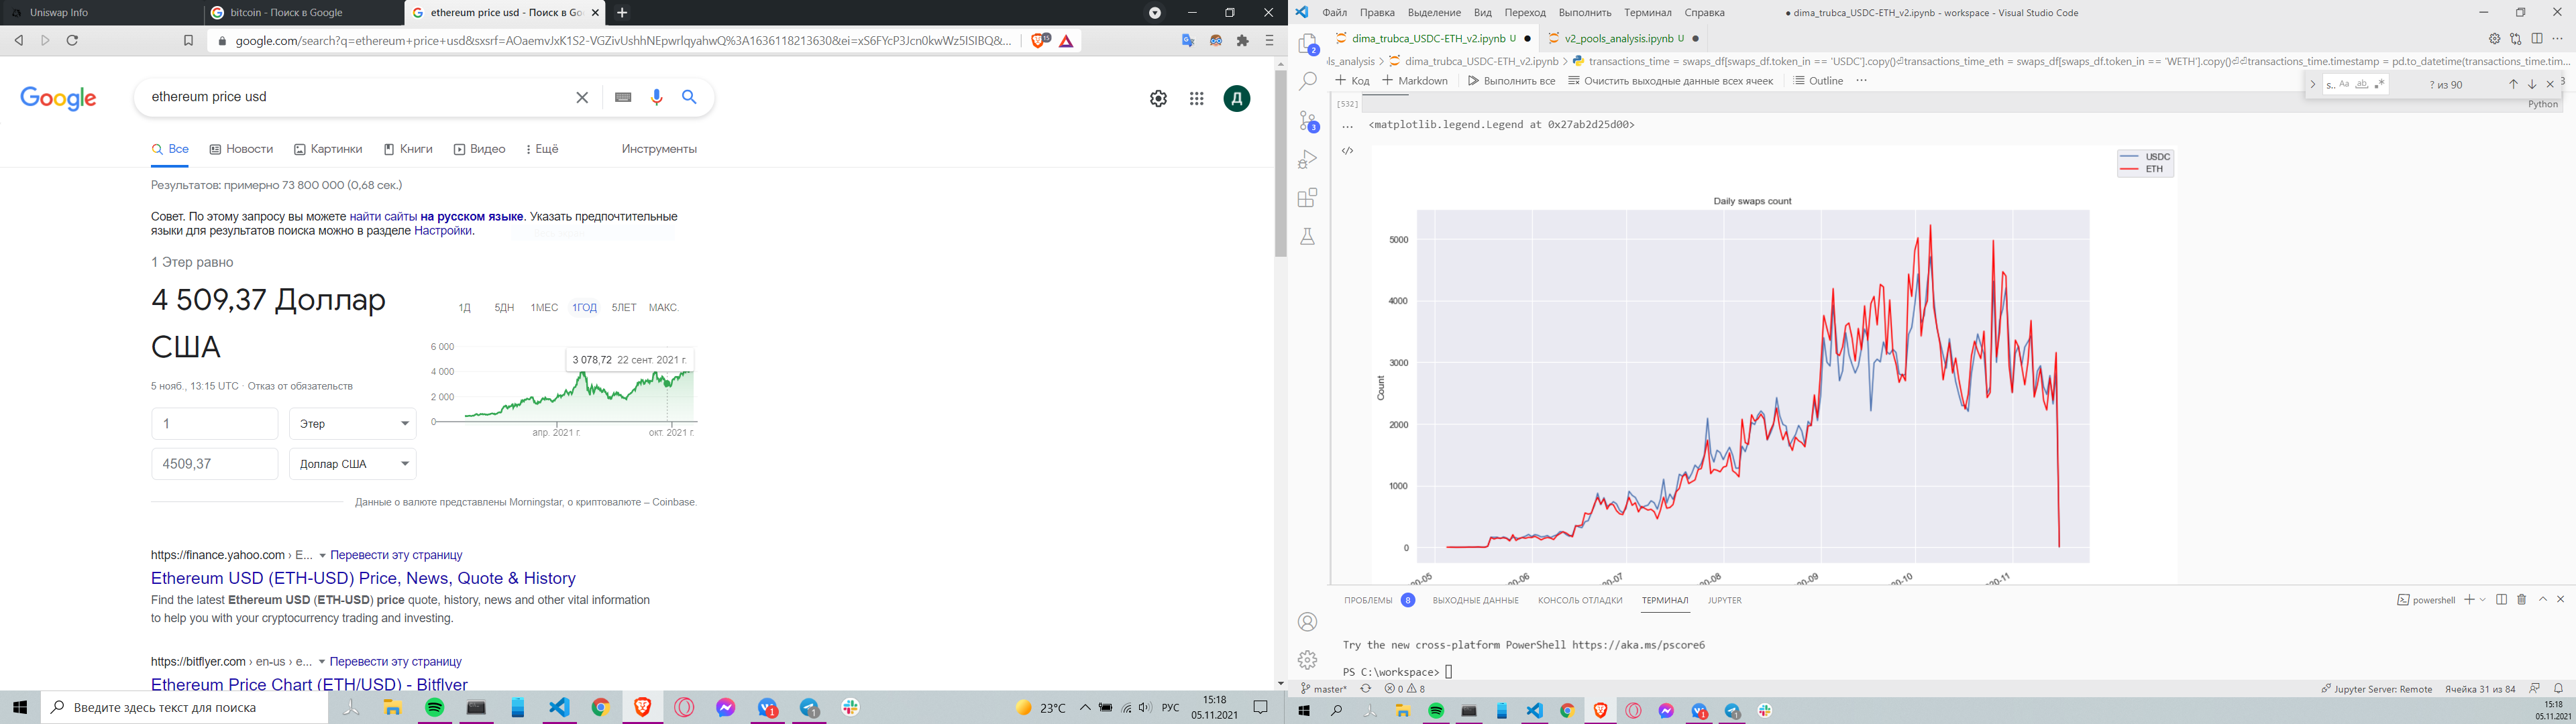

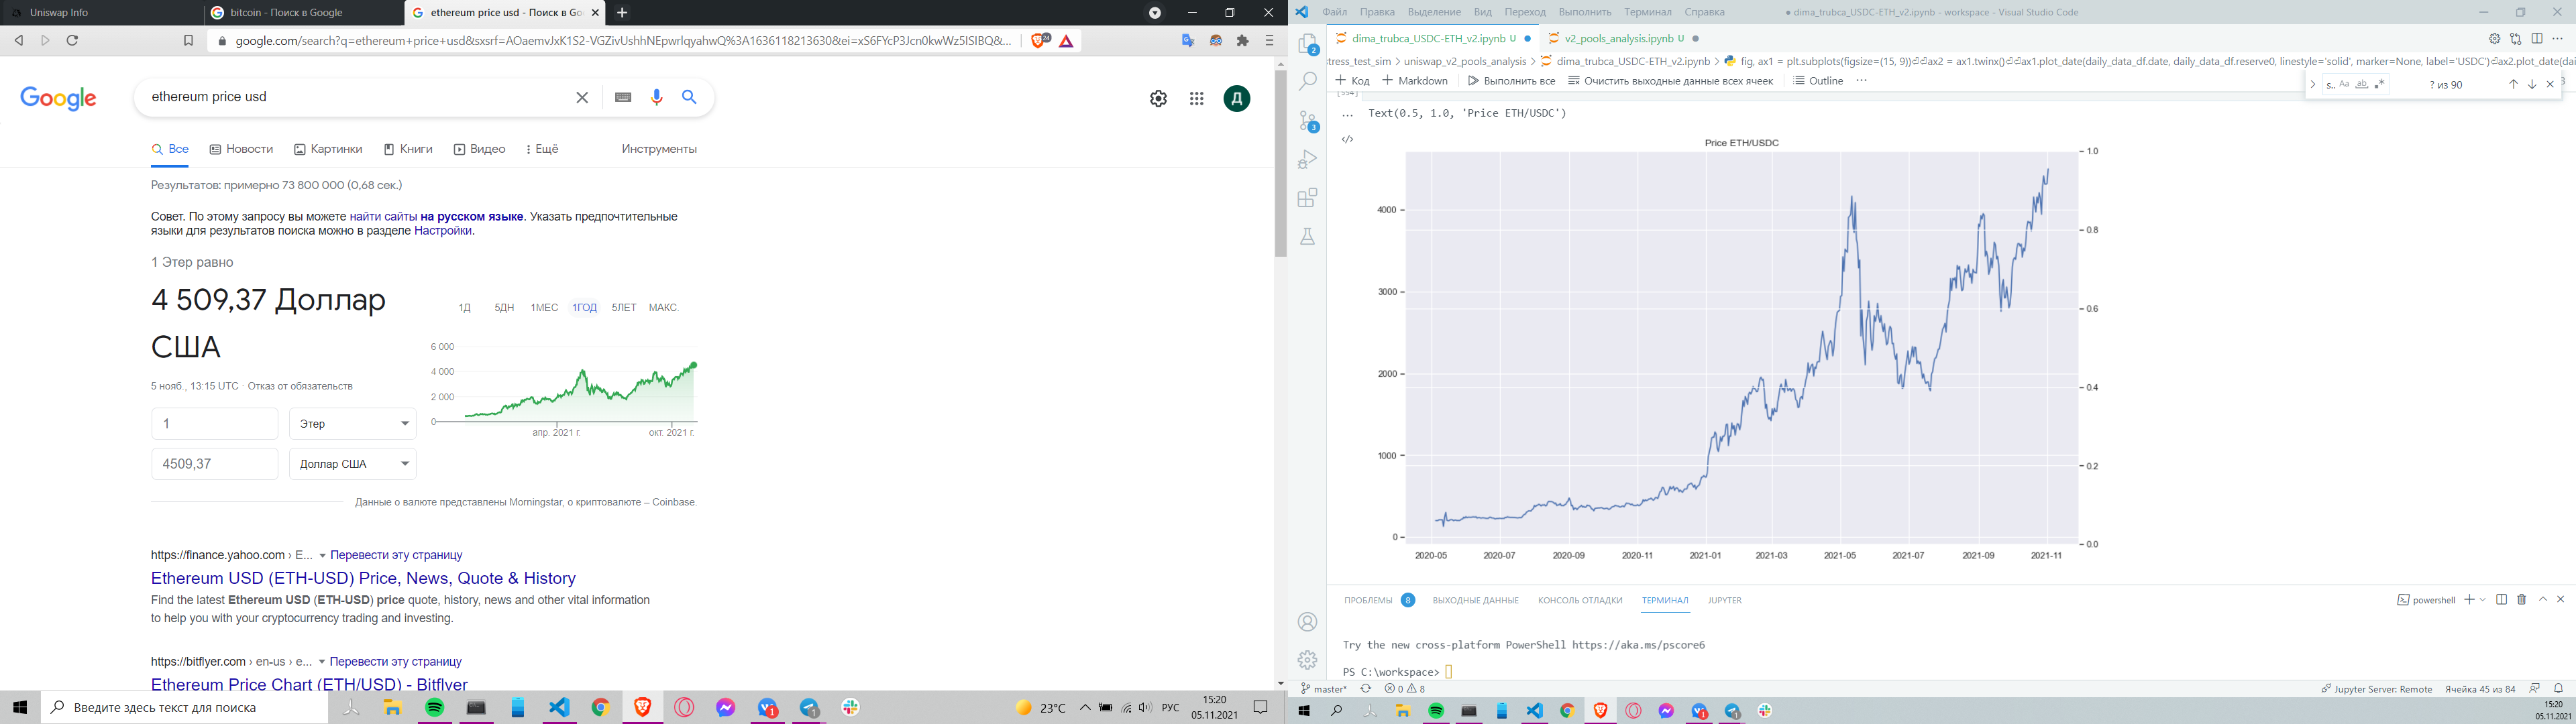

# ETH/USDT check and comparison with ETH/USDC

Considering ethereum price it will be interesting to compare story of this pool with story of previous one.

In [ ]:
eth_usdt_history = get_pool_v2_history(contract_id='0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852', range_limit=4000)
eth_usdt_df = pool_history_to_df(eth_usdt_history)

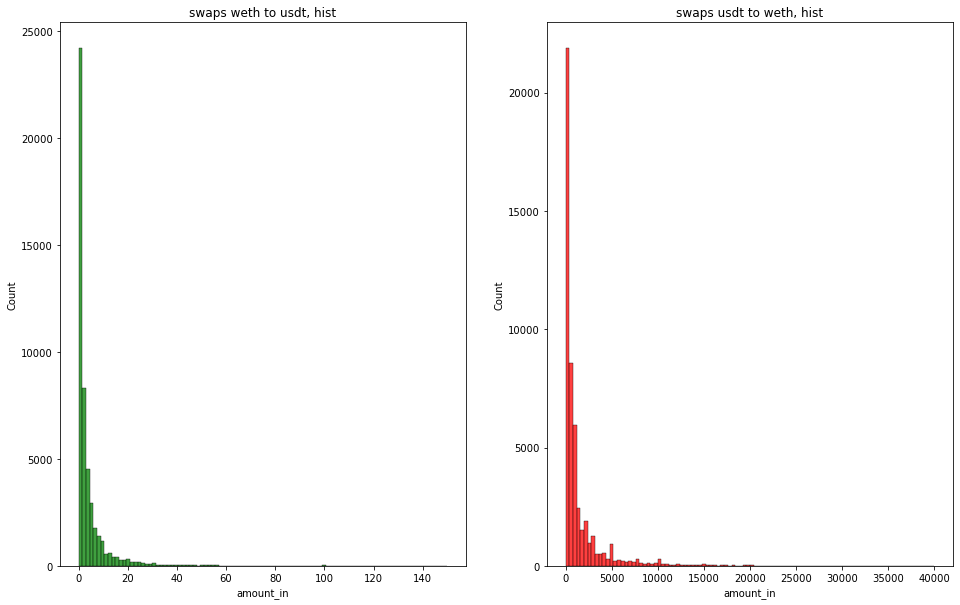

In [84]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
sns.histplot(eth_usdt_df[eth_usdt_df['token_in'] == 'WETH'].amount_in, bins=100, color='green', 
             binrange=[0, 150]).set_title('swaps weth to usdt, hist')

plt.subplot(1, 2, 2)
sns.histplot(eth_usdt_df[eth_usdt_df['token_in'] == 'USDT'].amount_in, bins=100, color='red', 
             binrange=[0, 40000]).set_title('swaps usdt to weth, hist')

plt.show()

Comparing the data of ETH/USDT pool and the data of ETH/USDC pool

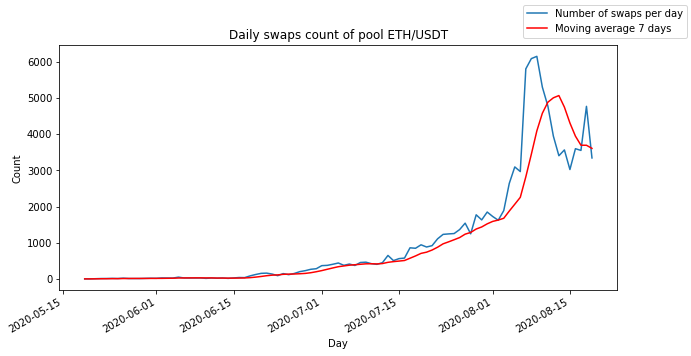

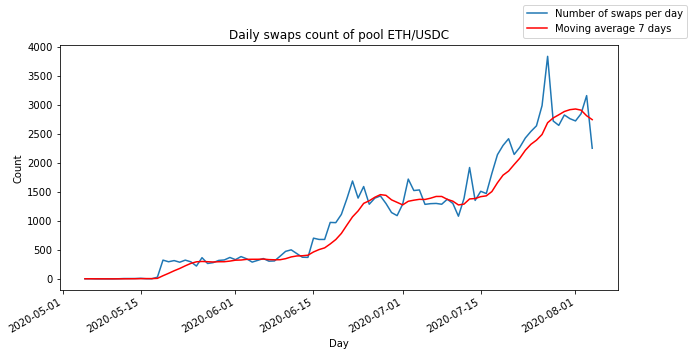

In [85]:
show_swaps_count_moving_averages(swaps_df=eth_usdt_df, pool_name="ETH/USDT")
show_swaps_count_moving_averages(swaps_df=eth_usdc_df, pool_name="ETH/USDC")

## Collecting reserves data for analysis

In [49]:
eth_usdt_reserves = get_pool_v2_reserves_history(contract_id="0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852")
eth_usdc_reserves = get_pool_v2_reserves_history(contract_id="0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc")

  0%|                                                                                                                                                                                       | 0/2 [00:00<?, ?it/s]

list index out of range


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

list index out of range


In [58]:
eth_usdc_reserves_df = pool_reserves_to_df(eth_usdc_reserves)
eth_usdt_reserves_df = pool_reserves_to_df(eth_usdt_reserves)

### Comparing reserves data for ETH/USDC and ETH/USDT

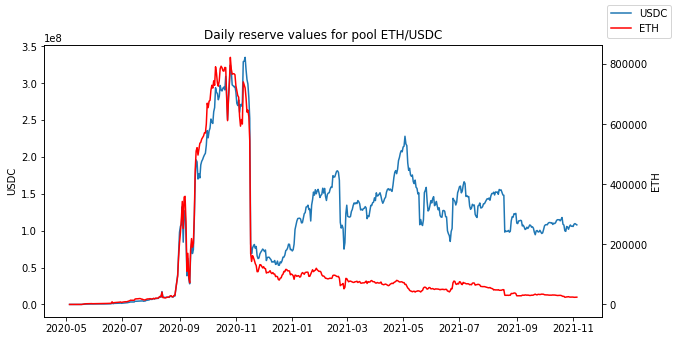

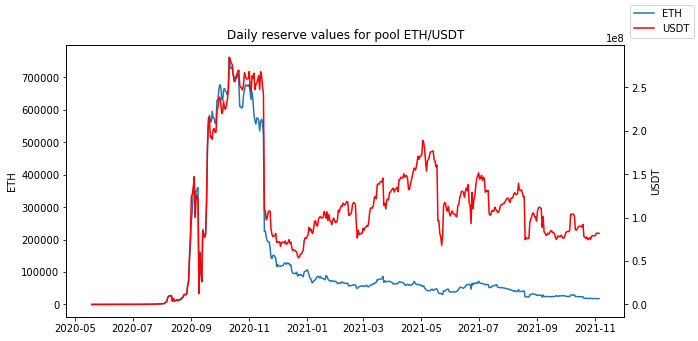

In [77]:
show_swaps_reserves_evolution_through_time(eth_usdc_reserves_df, first_token_symbol="USDC", second_token_symbol="ETH", 
                                           pool_name="ETH/USDC")
show_swaps_reserves_evolution_through_time(eth_usdt_reserves_df, first_token_symbol="ETH", second_token_symbol="USDT",
                                           pool_name="ETH/USDT")

### Comparing pool prices evolution for ETH/USDC and ETH/USDT

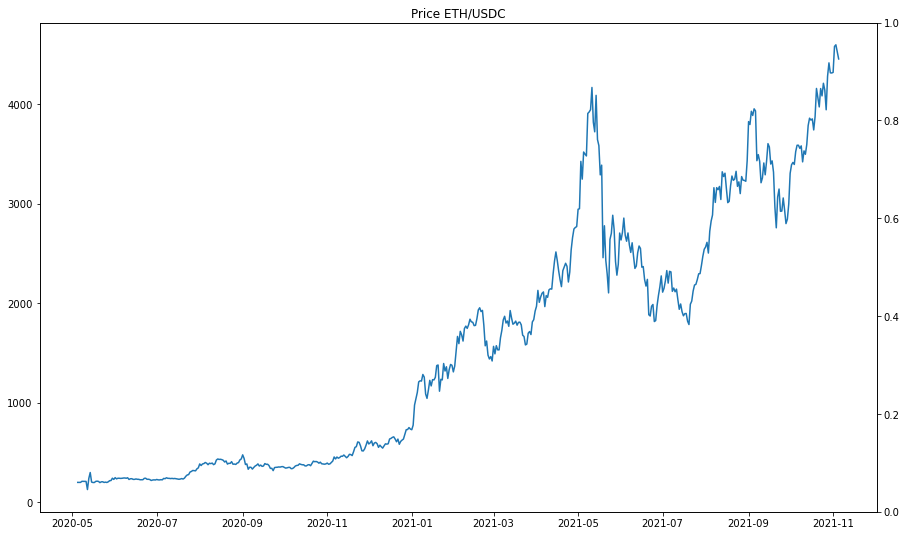

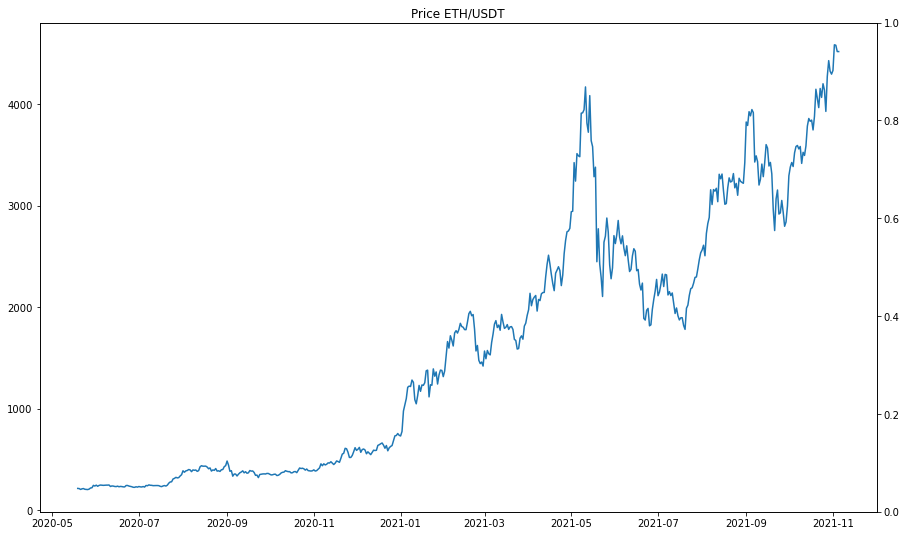

In [79]:
show_pool_price_evolution_from_reserves(eth_usdc_reserves_df, first_arg="reserve0", second_arg="reserve1", 
                                        pool_name="ETH/USDC")
show_pool_price_evolution_from_reserves(eth_usdt_reserves_df, first_arg="reserve1", second_arg="reserve0", 
                                        pool_name="ETH/USDT")

Results of the price evolution demonstrate that pool price is always stimulated to be equal to the real-market one. Distributions are very similar and their trends are similar.

**Suggestion to check**: charts show that there are drops in pool price. It will be interesting to check transactions what values are there. 

In [112]:
eth_usdc_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp
0,WETH,USDC,0.000005,0.001000,0.000501,1588712972
1,WETH,USDC,0.000049,0.010000,0.004965,1588713155
2,WETH,USDC,0.000005,0.001000,0.000501,1588782295
3,USDC,WETH,0.000689,0.000003,0.000344,1588791072
4,WETH,USDC,0.001000,0.204870,0.099533,1589202528
...,...,...,...,...,...,...
986995,WETH,USDC,7.500000,4649.791244,4653.902002,1608976870
986996,USDC,WETH,623.624728,1.000000,622.315481,1608976902
986997,USDC,WETH,989.072675,1.586041,987.009178,1608976902
986998,WETH,USDC,1.000000,619.888622,620.425380,1608976993


In [113]:
eth_usdc_df["date"] = pd.to_datetime(eth_usdc_df.timestamp, unit='s')

In [114]:
eth_usdt_df["date"] = pd.to_datetime(eth_usdt_df.timestamp, unit='s')

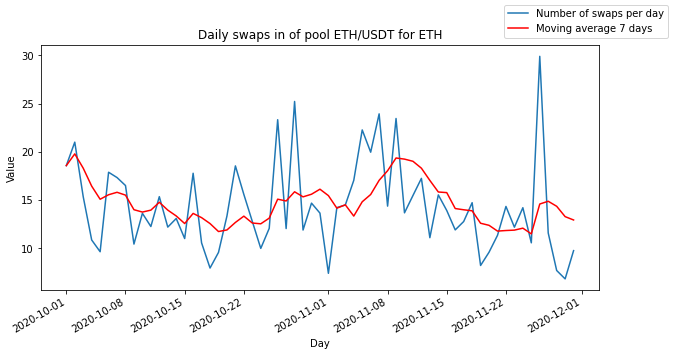

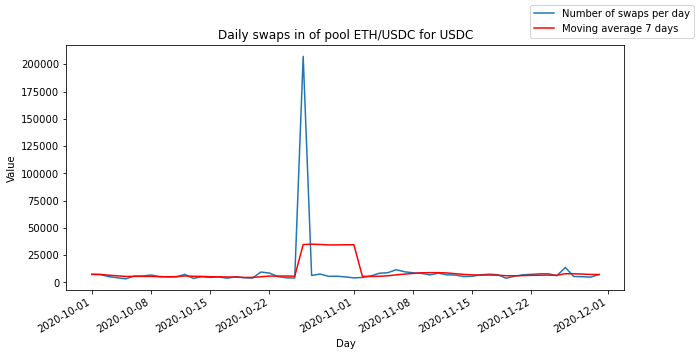

In [125]:
show_swaps_amount_in_moving_averages(swaps_df=eth_usdc_df[(eth_usdc_df.token_in == 'WETH') & (eth_usdc_df.date > datetime.datetime(2020, 10, 1)) & (eth_usdc_df.date < datetime.datetime(2020, 12, 1))], pool_name="ETH/USDT for ETH")
show_swaps_amount_in_moving_averages(swaps_df=eth_usdc_df[(eth_usdc_df.token_in == 'USDC') & (eth_usdc_df.date > datetime.datetime(2020, 10, 1)) & (eth_usdc_df.date < datetime.datetime(2020, 12, 1))], pool_name="ETH/USDC for USDC")

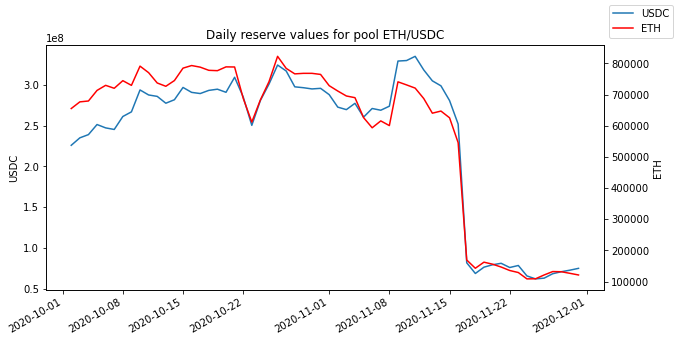

In [130]:
show_swaps_reserves_evolution_through_time(eth_usdc_reserves_df[(eth_usdc_reserves_df.date > datetime.datetime(2020, 10, 1)) & (eth_usdc_reserves_df.date < datetime.datetime(2020, 12, 1))], first_token_symbol="USDC", second_token_symbol="ETH", 
                                           pool_name="ETH/USDC")